<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/Framework_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Comparison of Reinforcement Learning Frameworks

This notebook is a companion to the blog post of the same name by Winder Research. Please view the blog post to gain context of what this is.

This is presented in a very raw format. It was primarily used to test out each of the frameworks. But if it is useful to you, then by all means feel free share it.

## Warning

This notebook is quite unstable. Each framework needs slightly different requirements and they all interact differently with colab.

Generally, if you see an error, a runtime restart usually fixes the problem. The cause is usually because the wrong version of a library is loaded.

In [0]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_vid(path):
  video = io.open(path, 'r+b').read()
  encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/mp4;base64,{0}" type="video/mp4" />
           </video>'''.format(encoded.decode('ascii'))))

# OpenAI Gym

In [0]:
!apt-get install -y xvfb python-opengl ffmpeg python-pyglet > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1017'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1017'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder # Because we want to record a video

env = gym.make("CartPole-v1") # Create the cartpole environment
env.reset()
rec = VideoRecorder(env)      # Create the video recorder
rec.capture_frame()           # Capture the starting position
while True:
    action = env.action_space.sample()                   # Use a random action
    observation, reward, done, info = env.step(action)   # to take a single step in the environment
    rec.capture_frame()                                  # and record
    if done:
           break                                         # If the pole has fallen, quit.
rec.close()  # Close the recording
env.close()  # Close the environment

In [0]:
show_vid(rec.path)

In [0]:
!pip install --upgrade --no-cache-dir dopamine-rl
!pip install gin-config

     |████████████████████████████████| 61kB 4.3MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-67cj6qhy/wheels/75/01/fa/43ebcfe0f37d8c27bb1b7b6fa213caa0340e783fe754a2af8f
Successfully built dopamine-rl
  Found existing installation: dopamine-rl 1.0.5
    Uninstalling dopamine-rl-1.0.5:
      Successfully uninstalled dopamine-rl-1.0.5


In [0]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf
import tensorflow as tf

BASE_PATH = '/tmp/colab_dopamine_run'  # @param


W0625 16:10:35.975975 140516433803136 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0625 16:10:35.984353 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/gin/tf/utils.py:34: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0625 16:10:35.986600 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/gin/tf/utils.py:34: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0625 16:10:35.991888 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/gin/tf/utils.py:43: The name tf.train.SessionRunHoo

In [0]:
# @title Load the configuration for DQN.

DQN_PATH = os.path.join(BASE_PATH, 'dqn')
# Modified from dopamine/agents/dqn/config/dqn_cartpole.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.circular_replay_buffer
import gin.tf.external_configurables

DQNAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
DQNAgent.observation_dtype = %gym_lib.CARTPOLE_OBSERVATION_DTYPE
DQNAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
DQNAgent.network = @gym_lib.cartpole_dqn_network
DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 500
DQNAgent.update_period = 4
DQNAgent.target_update_period = 100
DQNAgent.epsilon_fn = @dqn_agent.identity_epsilon
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.001
tf.train.AdamOptimizer.epsilon = 0.0003125

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_agent.agent_name = 'dqn'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 100
Runner.training_steps = 100
Runner.evaluation_steps = 100
Runner.max_steps_per_episode = 200  # Default max episode length.

WrappedReplayBuffer.replay_capacity = 50000
WrappedReplayBuffer.batch_size = 128
"""
gin.parse_config(dqn_config, skip_unknown=False)

W0625 16:10:36.035696 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/gin/tf/external_configurables.py:32: The name tf.train.exponential_decay is deprecated. Please use tf.compat.v1.train.exponential_decay instead.

W0625 16:10:36.037590 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/gin/tf/external_configurables.py:33: The name tf.train.inverse_time_decay is deprecated. Please use tf.compat.v1.train.inverse_time_decay instead.

W0625 16:10:36.039106 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/gin/tf/external_configurables.py:48: The name tf.losses.absolute_difference is deprecated. Please use tf.compat.v1.losses.absolute_difference instead.

W0625 16:10:36.041050 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/gin/tf/external_configurables.py:50: The name tf.losses.hinge_loss is deprecated. Please use tf.compat.v1.losses.h

In [0]:
# @title Train DQN on Cartpole
tf.reset_default_graph()
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

W0625 16:10:36.073584 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/dopamine/discrete_domains/run_experiment.py:506: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

W0625 16:10:36.077062 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/dopamine/discrete_domains/logger.py:48: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0625 16:10:36.079235 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/dopamine/discrete_domains/run_experiment.py:183: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0625 16:10:36.084795 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/dopamine/discrete_domains/run_experiment.py:186: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0625 16:10:36.086

Will train DQN agent, please be patient, may be a while...


W0625 16:10:37.905010 140516433803136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/dopamine/discrete_domains/logger.py:89: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0625 16:10:39.675085 140516433803136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Done training!


In [0]:
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder # Because we want to record a video

rec = VideoRecorder(dqn_runner._environment.environment)
action = dqn_runner._initialize_episode()
rec.capture_frame()
while True:
    observation, reward, is_terminal = dqn_runner._run_one_step(action)
    rec.capture_frame()
    if is_terminal:
      break                                         # If the pole has fallen, quit.
    else:
      action = dqn_runner._agent.step(reward, observation)
dqn_runner._end_episode(reward)
rec.close()

In [0]:
show_vid(rec.path)

# Ray

Note that if you running this code on Google colab then you must restart the runtime after uninstalling pyarrow below or else ray will error out.

In [0]:
!pip uninstall -y pyarrow
!pip install tensorflow ray[rllib] > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg python-pyglet > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

W0625 19:30:17.028367 140180297578368 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import ray
from ray import tune

ray.init()

In [0]:
tune.run(
    "DQN",
    stop={"episode_reward_mean": 100},
    config={
        "env": "CartPole-v0",
        "num_gpus": 0,
        "num_workers": 1,
        "lr": tune.grid_search([0.01, 0.001, 0.0001]),
        "monitor": False,
    },
)


2019-06-25 19:44:53,022	INFO tune.py:61 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-06-25 19:44:53,024	INFO tune.py:232 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs, 0/0 GPUs
Memory usage on this node: 1.9/13.7 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/2 CPUs, 0/0 GPUs
Memory usage on this node: 1.9/13.7 GB
Result logdir: /root/ray_results/DQN
Number of trials: 3 ({'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - DQN_CartPole-v0_1_lr=0.001:	PENDING
 - DQN_CartPole-v0_2_lr=0.0001:	PENDING
RUNNING trials:
 - DQN_CartPole-v0_0_lr=0.01:	RUNNING

(pid=1351) WARNING: Logging before flag parsing goes to stderr.
(pid=1351) W0625 19:45:02.178079 140633306634112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/v2_compat.py:61: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1351) Instructions for updating:
(pid=1351) non-resource variables are not supported in the long term
(pid=1351) 2019-06-25 19:45:03,067	INFO policy_evaluator.py

W0625 19:45:35.022074 140180297578368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/ray/tune/logger.py:114: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



Result for DQN_CartPole-v0_0_lr=0.01:
  custom_metrics: {}
  date: 2019-06-25_19-45-34
  done: false
  episode_len_mean: 23.476190476190474
  episode_reward_max: 65.0
  episode_reward_mean: 23.476190476190474
  episode_reward_min: 10.0
  episodes_this_iter: 42
  episodes_total: 42
  experiment_id: 6dd8564ee1634871b517d2893d4bb054
  hostname: 16244a9ca08f
  info:
    grad_time_ms: .nan
    learner: {}
    max_exploration: 1.0
    min_exploration: 1.0
    num_steps_sampled: 1000
    num_steps_trained: 0
    num_target_updates: 1
    opt_peak_throughput: 0.0
    opt_samples: .nan
    replay_time_ms: .nan
    sample_time_ms: 49.79
    update_time_ms: 41.697
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  num_metric_batches_dropped: 0
  off_policy_estimator: {}
  pid: 1351
  policy_reward_mean: {}
  sampler_perf:
    mean_env_wait_ms: 0.21874249636471926
    mean_inference_ms: 2.3641448159079683
    mean_processing_ms: 0.4266613608711844
  time_since_restore: 

2019-06-25 19:52:16,217	INFO ray_trial_executor.py:187 -- Destroying actor for trial DQN_CartPole-v0_0_lr=0.01. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for DQN_CartPole-v0_0_lr=0.01:
  custom_metrics: {}
  date: 2019-06-25_19-52-16
  done: true
  episode_len_mean: 105.34
  episode_reward_max: 200.0
  episode_reward_mean: 105.34
  episode_reward_min: 8.0
  episodes_this_iter: 5
  episodes_total: 424
  experiment_id: 6dd8564ee1634871b517d2893d4bb054
  hostname: 16244a9ca08f
  info:
    grad_time_ms: 14.193
    learner:
      default_policy:
        cur_lr: 0.009999999776482582
        max_q: 40.740264892578125
        mean_q: 36.757164001464844
        mean_td_error: 3.181473731994629
        min_q: 11.437118530273438
        model: {}
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 22000
    num_steps_trained: 168000
    num_target_updates: 43
    opt_peak_throughput: 2254.627
    opt_samples: 32.0
    replay_time_ms: 5.22
    sample_time_ms: 16.0
    update_time_ms: 13.907
  iterations_since_restore: 22
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  num_metric_batches

2019-06-25 19:56:37,699	INFO ray_trial_executor.py:187 -- Destroying actor for trial DQN_CartPole-v0_1_lr=0.001. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for DQN_CartPole-v0_1_lr=0.001:
  custom_metrics: {}
  date: 2019-06-25_19-56-37
  done: true
  episode_len_mean: 101.62
  episode_reward_max: 200.0
  episode_reward_mean: 101.62
  episode_reward_min: 12.0
  episodes_this_iter: 5
  episodes_total: 229
  experiment_id: 0e448c35d47f480abb7df1669ee7a6e3
  hostname: 16244a9ca08f
  info:
    grad_time_ms: 12.525
    learner:
      default_policy:
        cur_lr: 0.0010000000474974513
        max_q: 23.366138458251953
        mean_q: 18.686616897583008
        mean_td_error: 0.29401248693466187
        min_q: 1.5325549840927124
        model: {}
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 13000
    num_steps_trained: 96000
    num_target_updates: 25
    opt_peak_throughput: 2554.883
    opt_samples: 32.0
    replay_time_ms: 5.296
    sample_time_ms: 17.463
    update_time_ms: 13.157
  iterations_since_restore: 13
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  num_metric_

2019-06-25 20:01:14,624	INFO ray_trial_executor.py:187 -- Destroying actor for trial DQN_CartPole-v0_2_lr=0.0001. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for DQN_CartPole-v0_2_lr=0.0001:
  custom_metrics: {}
  date: 2019-06-25_20-01-14
  done: true
  episode_len_mean: 102.42
  episode_reward_max: 200.0
  episode_reward_mean: 102.42
  episode_reward_min: 10.0
  episodes_this_iter: 5
  episodes_total: 268
  experiment_id: 75a0bdcf9f8c491d9c0f027ebb3da5f4
  hostname: 16244a9ca08f
  info:
    grad_time_ms: 12.32
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 26.84748077392578
        mean_q: 20.581289291381836
        mean_td_error: 5.6687822341918945
        min_q: 6.800024509429932
        model: {}
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 14000
    num_steps_trained: 104000
    num_target_updates: 27
    opt_peak_throughput: 2597.464
    opt_samples: 32.0
    replay_time_ms: 5.815
    sample_time_ms: 14.992
    update_time_ms: 16.876
  iterations_since_restore: 14
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  num_metric_ba

[DQN_CartPole-v0_0_lr=0.01,
 DQN_CartPole-v0_1_lr=0.001,
 DQN_CartPole-v0_2_lr=0.0001]

# Keras-RL

In [0]:
!apt-get install -y xvfb python-opengl ffmpeg python-pyglet > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install keras-rl > /dev/null 2>&1

In [0]:
from pyvirtualdisplay import Display
from gym.wrappers.monitor import Monitor
display = Display(visible=0, size=(1400, 900))
display.start()

import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


ENV_NAME = 'CartPole-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=5000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=2500, visualize=True, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(Monitor(env, '.'), nb_episodes=5, visualize=True)

W0625 20:17:55.664429 140008805877632 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_7 (Activation)    (None, 16)                0         
__________

/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   31/2500: episode: 1, duration: 1.962s, episode steps: 31, steps per second: 16, episode reward: 31.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.419 [0.000, 1.000], mean observation: 0.013 [-1.185, 1.776], loss: 0.462357, mean_absolute_error: 0.519609, mean_q: 0.093506
   44/2500: episode: 2, duration: 0.126s, episode steps: 13, steps per second: 103, episode reward: 13.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.692 [0.000, 1.000], mean observation: -0.069 [-1.867, 1.224], loss: 0.353314, mean_absolute_error: 0.539802, mean_q: 0.283920


/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   64/2500: episode: 3, duration: 0.191s, episode steps: 20, steps per second: 105, episode reward: 20.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.550 [0.000, 1.000], mean observation: -0.070 [-1.375, 0.833], loss: 0.230543, mean_absolute_error: 0.559043, mean_q: 0.496762
   83/2500: episode: 4, duration: 0.170s, episode steps: 19, steps per second: 112, episode reward: 19.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.421 [0.000, 1.000], mean observation: 0.074 [-0.817, 1.505], loss: 0.116567, mean_absolute_error: 0.603374, mean_q: 0.820932
   98/2500: episode: 5, duration: 0.131s, episode steps: 15, steps per second: 114, episode reward: 15.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.600 [0.000, 1.000], mean observation: -0.090 [-1.368, 0.825], loss: 0.051994, mean_absolute_error: 0.665641, mean_q: 1.135469
  114/2500: episode: 6, duration: 0.153s, episode steps: 16, steps per second: 105, episode reward: 16.000, mean reward: 1.000 [1.000, 1.000], mean a

In [0]:
show_vid(next(glob.iglob("*.mp4")))

# Tensorforce

In [0]:
!pip install tensorforce tensorforce[tf] > /dev/null 2>&1


In [0]:
from pyvirtualdisplay import Display
from gym.wrappers.monitor import Monitor
display = Display(visible=0, size=(1400, 900))
display.start()

import urllib.request, json 
import time

from tensorforce import TensorForceError
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym

environment = OpenAIGym(
    gym_id="CartPole-v0",
    monitor=".",
    monitor_safe=False,
    monitor_video=10,
    visualize=True
)

with urllib.request.urlopen("https://raw.githubusercontent.com/tensorforce/tensorforce/master/examples/configs/dqn.json") as url:
  agent = json.loads(url.read().decode())
  print(agent)
with urllib.request.urlopen("https://raw.githubusercontent.com/tensorforce/tensorforce/master/examples/configs/mlp2_network.json") as url:
  network = json.loads(url.read().decode())
  print(network)
  
agent = Agent.from_spec(
  spec=agent,
  kwargs=dict(
    states=environment.states,
    actions=environment.actions,
    network=network
  )
)

runner = Runner(
    agent=agent,
    environment=environment,
    repeat_actions=1
)

runner.run(
    num_timesteps=200,
    num_episodes=200,
    max_episode_timesteps=200,
    deterministic=True,
    testing=False,
    sleep=None
)
runner.close()

W0626 12:55:04.124785 139879278864256 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


{'type': 'dqn_agent', 'update_mode': {'unit': 'timesteps', 'batch_size': 64, 'frequency': 4}, 'memory': {'type': 'replay', 'capacity': 10000, 'include_next_states': True}, 'optimizer': {'type': 'clipped_step', 'clipping_value': 0.1, 'optimizer': {'type': 'adam', 'learning_rate': 0.001}}, 'discount': 0.99, 'entropy_regularization': None, 'double_q_model': True, 'target_sync_frequency': 1000, 'target_update_weight': 1.0, 'actions_exploration': {'type': 'epsilon_anneal', 'initial_epsilon': 0.5, 'final_epsilon': 0.0, 'timesteps': 10000}, 'saver': {'directory': None, 'seconds': 600}, 'summarizer': {'directory': None, 'labels': ['graph', 'total-loss']}, 'execution': {'type': 'single', 'session_config': None, 'distributed_spec': None}}
[{'type': 'dense', 'size': 32, 'activation': 'relu'}, {'type': 'dense', 'size': 32, 'activation': 'relu'}]


I0626 12:55:06.718917 139879278864256 monitored_session.py:240] Graph was finalized.
I0626 12:55:06.886334 139879278864256 session_manager.py:500] Running local_init_op.
I0626 12:55:06.908234 139879278864256 session_manager.py:502] Done running local_init_op.
I0626 12:55:08.367528 139879278864256 <ipython-input-10-bfd5102b369a>:54] Learning finished. Total episodes: 22


In [0]:
show_vid(next(glob.iglob("*.mp4")))

# Coach

Note: Once you have installed the below, you will need to restart the runtime. Coach needs a newer version of gym.

In [0]:
!pip install rl_coach > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg python-pyglet > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install gym==0.12.5

     |████████████████████████████████| 1.5MB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/cf/a5/c9/87967963aa32540d543e51bcf0d0fc19c5d68b8f49598d3b98
Successfully built gym
  Found existing installation: gym 0.10.11
    Uninstalling gym-0.10.11:
      Successfully uninstalled gym-0.10.11


In [0]:
from pyvirtualdisplay import Display
from gym.wrappers.monitor import Monitor
display = Display(visible=0, size=(1400, 900))
display.start()

import tensorflow as tf
tf.reset_default_graph()

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps
from rl_coach.base_parameters import VisualizationParameters
global experiment_path; experiment_path = '.'


# schedule
schedule_params = ScheduleParameters()
schedule_params.improve_steps = TrainingSteps(200)
schedule_params.steps_between_evaluation_periods = EnvironmentSteps(200)
schedule_params.evaluation_steps = EnvironmentEpisodes(200)
schedule_params.heatup_steps = EnvironmentSteps(0)

graph_manager = BasicRLGraphManager(
    agent_params=ClippedPPOAgentParameters(),
    env_params=GymVectorEnvironment(level='CartPole-v0'),
    schedule_params=schedule_params,
    vis_params=VisualizationParameters(dump_mp4=True)
)

W0626 20:39:25.517042 140162082756480 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
graph_manager.improve()

Creating graph - name: BasicRLGraphManager
Creating agent - name: agent
Starting to improve simple_rl_graph task index 0
Training - Name: main_level/agent Worker: 0 Episode: 1 Total reward: 23.0 Steps: 23 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 2 Total reward: 14.0 Steps: 37 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 3 Total reward: 19.0 Steps: 56 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 4 Total reward: 20.0 Steps: 76 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 5 Total reward: 25.0 Steps: 101 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 6 Total reward: 36.0 Steps: 137 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 7 Total reward: 24.0 Steps: 161 Training iteration: 0 
Training - Name: main_level/agent Worker: 0 Episode: 8 Total reward: 14.0 Steps: 175 Training iteration: 0 
agent: Starting eva

In [0]:
show_vid(next(glob.iglob("experiments/test/**/videos/*.mp4")))

# MAgent

In [0]:
!apt-get install -y xvfb python-opengl ffmpeg python-pyglet > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [0]:
!git clone https://github.com/geek-ai/MAgent.git
!sudo apt-get install cmake libboost-system-dev libjsoncpp-dev libwebsocketpp-dev
%cd MAgent
!bash build.sh

fatal: destination path 'MAgent' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2).
libboost-system-dev is already the newest version (1.65.1.0ubuntu1).
libjsoncpp-dev is already the newest version (1.7.4-3).
libwebsocketpp-dev is already the newest version (0.7.0-11).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/content/MAgent
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX co

In [0]:
!PYTHONPATH=$(pwd)/python:$PYTHONPATH python examples/api_demo.py

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


W0627 09:24:39.824534 139869075769216 deprecation_wrapper.py:119] From /content/MAgent/python/magent/builtin/tf_model/dqn.py:81: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 09:24:39.843531 139869075769216 deprecation_wrapper.py:119] From /content/MAgent/python/magent/builtin/tf_model/dqn.py:91: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0627 09:24:39.844067 139869075769216 deprecation_wrapper.py:119] From /content/MAgent/python/magent/builtin/tf_model/dqn.py:93: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0627 09:24:39.844260 139869075769216 deprecation.py:323] From /content/MAgent/python/magent/builtin/tf_model/dqn.py:165: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0627 09:24:39.848146 139869075769216 depre

# SLM-Lab

In [0]:
%cd /content
!ls

/content
build  MAgent  sample_data  SLM-Lab


In [0]:
!git clone https://github.com/kengz/SLM-Lab.git
%cd /content/SLM-Lab

fatal: destination path 'SLM-Lab' already exists and is not an empty directory.
/content/SLM-Lab


In [0]:
!pip install pydash==4.2.1 regex==2019.05.25 ujson==1.35 colorlog==4.0.2 ray==0.7.0 torch==1.1.0

In [0]:
!python run_lab.py slm_lab/spec/demo.json dqn_cartpole dev

Traceback (most recent call last):
  File "run_lab.py", line 77, in <module>
    mp.set_start_method('spawn')  # for distributed pytorch to work
  File "/usr/lib/python3.6/multiprocessing/context.py", line 242, in set_start_method
    raise RuntimeError('context has already been set')
RuntimeError: context has already been set


# DeeR

In [0]:
!pip install git+git://github.com/VINF/deer.git@master
!git clone https://github.com/VinF/deer.git

  Cloning git://github.com/VINF/deer.git (to revision master) to /tmp/pip-req-build-q7rqqsoq
  Running command git clone -q git://github.com/VINF/deer.git /tmp/pip-req-build-q7rqqsoq
  Stored in directory: /tmp/pip-ephem-wheel-cache-ed1ixq74/wheels/22/ce/b3/62316fcd701b75f1c255c84026db5efc518cd9595488dc7e2a
Successfully built deer
Cloning into 'deer'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2977 (delta 0), reused 0 (delta 0), pack-reused 2976
Receiving objects: 100% (2977/2977), 12.83 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (2043/2043), done.


In [0]:
%cd /content/deer/examples/toy_env
import numpy as np
from deer.agent import NeuralAgent
from deer.learning_algos.q_net_keras import MyQNetwork
from Toy_env import MyEnv as Toy_env
import deer.experiment.base_controllers as bc


/content/deer/examples/toy_env


W0628 08:24:58.046045 140240255469440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 08:24:58.102065 140240255469440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 08:24:58.130126 140240255469440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 08:24:58.245688 140240255469440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 08:24:58.367403 140240255469440 deprecation_wrappe

Average (on the epoch) training loss: 0.14866669476032257
Episode average V value: 0.06669619510631186
epoch 1:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
Average (on the epoch) training loss: 0.1299528181552887
Episode average V value: 0.17194478684011846
epoch 2:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
Average (on the epoch) training loss: 0.1677785962820053
Episode average V value: 0.17891222828626632
epoch 3:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
Average (on the epoch) training loss: 0.24310679733753204
Episode average V value: 0.16639169204235077
epoch 4:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
Average (on the epoch) training loss: 0.2669770419597626
E

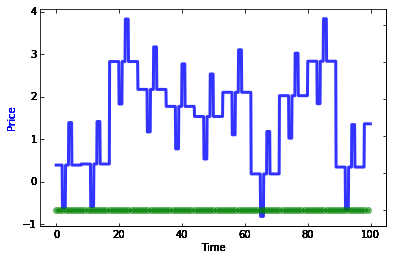

In [0]:
rng = np.random.RandomState(123456)

# --- Instantiate environment ---
env = Toy_env(rng)

# --- Instantiate qnetwork ---
qnetwork = MyQNetwork(
    environment=env,
    random_state=rng)

# --- Instantiate agent ---
agent = NeuralAgent(
    env,
    qnetwork,
    random_state=rng)

# --- Bind controllers to the agent ---
# Before every training epoch, we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController())

# During training epochs, we want to train the agent after every action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode.
agent.attach(bc.TrainerController())

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "test epoch" between each training epoch. We do not want these test epoch to interfere with the training of the 
# agent. Therefore, we will disable these controllers for the whole duration of the test epochs interleaved this 
# way, using the controllersToDisable argument of the InterleavedTestEpochController. The value of this argument 
# is a list of the indexes of all controllers to disable, their index reflecting in which order they were added.
agent.attach(bc.InterleavedTestEpochController(
    epoch_length=500, 
    controllers_to_disable=[0, 1]))
    
# --- Run the experiment ---
agent.run(n_epochs=100, epoch_length=1000)

# RLgraph

In [0]:
!pip install rlgraph gym pygame > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg python-pyglet > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [0]:
import os
os.mkdir("configs")
import urllib.request 
urllib.request.urlretrieve("https://raw.githubusercontent.com/rlgraph/rlgraph/master/examples/configs/dqn_cartpole.json", "configs/dqn_cartpole.json")

('configs/dqn_cartpole.json', <http.client.HTTPMessage at 0x7f953b5ccd30>)

In [0]:
from pyvirtualdisplay import Display
from gym.wrappers.monitor import Monitor
display = Display(visible=0, size=(1400, 900))
display.start()

import numpy as np
from rlgraph.agents import DQNAgent
from rlgraph.environments import OpenAIGymEnv
from rlgraph.execution import SingleThreadedWorker

environment = OpenAIGymEnv('CartPole-v0', monitor=".", monitor_video=1, visualize=True)

# Create from .json file or dict, see agent API for all
# possible configuration parameters.
agent = DQNAgent.from_file(
  "configs/dqn_cartpole.json",
  state_space=environment.state_space, 
  action_space=environment.action_space
)

episode_returns = []

def episode_finished_callback(episode_return, duration, timesteps, **kwargs):
  episode_returns.append(episode_return)
  if len(episode_returns) % 10 == 0:
    print("Episode {} finished: reward={:.2f}, average reward={:.2f}.".format(
      len(episode_returns), episode_return, np.mean(episode_returns[-10:])
    ))

worker = SingleThreadedWorker(env_spec=lambda: environment, agent=agent, render=True, worker_executes_preprocessing=False,
                              episode_finish_callback=episode_finished_callback)
print("Starting workload, this will take some time for the agents to build.")

# Use exploration is true for training, false for evaluation.
worker.execute_timesteps(1000, use_exploration=True)

W0628 19:17:14.603792 140280332130176 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


19-06-28 19:17:14:WARNING:xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


I0628 19:17:14.928444 140280332130176 agent.py:100] Parsed state space definition: Floatbox((4,) <class 'numpy.float32'> )


19-06-28 19:17:14:INFO:Parsed state space definition: Floatbox((4,) <class 'numpy.float32'> )


I0628 19:17:14.933475 140280332130176 agent.py:103] Parsed action space definition: Intbox(() <class 'numpy.int32'> )


19-06-28 19:17:14:INFO:Parsed action space definition: Intbox(() <class 'numpy.int32'> )


I0628 19:17:14.948281 140280332130176 agent.py:127] No preprocessing required.


19-06-28 19:17:14:INFO:No preprocessing required.


I0628 19:17:15.003520 140280332130176 graph_executor.py:66] Execution spec is: {'mode': 'single', 'distributed_spec': None, 'disable_monitoring': False, 'gpu_spec': {'gpus_enabled': False, 'max_usable_gpus': 0, 'fake_gpus_if_necessary': False, 'cuda_devices': None, 'per_process_gpu_memory_fraction': None, 'allow_memory_growth': False}, 'device_strategy': 'default', 'default_device': None, 'device_map': {}, 'session_config': {'type': 'monitored-training-session', 'allow_soft_placement': True, 'log_device_placement': False}, 'seed': None, 'enable_profiler': False, 'profiler_frequency': 1000, 'enable_timeline': False, 'timeline_frequency': 1}


Expose API sync from synchronizable to dueling-policy code:
@rlgraph_api(component=self, must_be_complete=False, ok_to_overwrite=False)
def sync(self, values_, ):
	return getattr(self.sub_components['synchronizable'], 'sync')(values_)

19-06-28 19:17:15:INFO:Execution spec is: {'mode': 'single', 'distributed_spec': None, 'disable_monitoring': False, 'gpu_spec': {'gpus_enabled': False, 'max_usable_gpus': 0, 'fake_gpus_if_necessary': False, 'cuda_devices': None, 'per_process_gpu_memory_fraction': None, 'allow_memory_growth': False}, 'device_strategy': 'default', 'default_device': None, 'device_map': {}, 'session_config': {'type': 'monitored-training-session', 'allow_soft_placement': True, 'log_device_placement': False}, 'seed': None, 'enable_profiler': False, 'profiler_frequency': 1000, 'enable_timeline': False, 'timeline_frequency': 1}


W0628 19:17:15.006790 140280332130176 tensorflow_executor.py:136] `device_map` given for device-strategy=`default`. Map will be ignored. Use device-strategy=`custom` together with a `device_map`.


19-06-28 19:17:15:WARNING:`device_map` given for device-strategy=`default`. Map will be ignored. Use device-strategy=`custom` together with a `device_map`.


I0628 19:17:15.009473 140280332130176 tensorflow_executor.py:139] Initializing graph executor with default device strategy. Backend will assign all visible devices.


19-06-28 19:17:15:INFO:Initializing graph executor with default device strategy. Backend will assign all visible devices.


I0628 19:17:15.013883 140280332130176 tensorflow_executor.py:141] GPUs enabled: False. Usable GPUs: None


19-06-28 19:17:15:INFO:GPUs enabled: False. Usable GPUs: None


I0628 19:17:15.049511 140280332130176 graph_executor.py:244] Components created: 50


19-06-28 19:17:15:INFO:Components created: 50


I0628 19:17:25.299105 140280332130176 meta_graph_builder.py:134] Meta-graph build completed in 10.247604421000005 s.


19-06-28 19:17:25:INFO:Meta-graph build completed in 10.247604421000005 s.


I0628 19:17:25.303957 140280332130176 meta_graph_builder.py:138] Meta-graph op-records generated: 809


19-06-28 19:17:25:INFO:Meta-graph op-records generated: 809


I0628 19:17:32.666053 140280332130176 graph_builder.py:210] Computation-Graph build completed in 7.356028490999961 s (87 iterations).


19-06-28 19:17:32:INFO:Computation-Graph build completed in 7.356028490999961 s (87 iterations).


I0628 19:17:32.694278 140280332130176 graph_builder.py:214] Actual graph ops generated: 1221


19-06-28 19:17:32:INFO:Actual graph ops generated: 1221


I0628 19:17:32.696989 140280332130176 graph_builder.py:217] Number of trainable parameters: 238


19-06-28 19:17:32:INFO:Number of trainable parameters: 238


I0628 19:17:32.700151 140280332130176 tensorflow_executor.py:727] Checking if all visible devices are in use for strategy: default. Available devices are: ['/device:CPU:0'].


19-06-28 19:17:32:INFO:Checking if all visible devices are in use for strategy: default. Available devices are: ['/device:CPU:0'].


W0628 19:17:32.705060 140280332130176 tensorflow_executor.py:731] Warning: Device /device:CPU:0 is usable but has not been assigned.


19-06-28 19:17:32:WARNING:Warning: Device /device:CPU:0 is usable but has not been assigned.


I0628 19:17:33.017920 140280332130176 tensorflow_executor.py:575] Setting up singular monitored session for non-distributed mode. Session config: allow_soft_placement: true



19-06-28 19:17:33:INFO:Setting up singular monitored session for non-distributed mode. Session config: allow_soft_placement: true



I0628 19:17:33.089520 140280332130176 monitored_session.py:240] Graph was finalized.


19-06-28 19:17:33:INFO:Graph was finalized.


I0628 19:17:33.288555 140280332130176 session_manager.py:500] Running local_init_op.


19-06-28 19:17:33:INFO:Running local_init_op.


I0628 19:17:33.323627 140280332130176 session_manager.py:502] Done running local_init_op.


19-06-28 19:17:33:INFO:Done running local_init_op.


I0628 19:17:33.394548 140280332130176 single_threaded_worker.py:39] Initialized single-threaded executor with 1 environments 'OpenAIGym(<Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>)' and Agent 'DQNAgent(doubleQ=True duelingQ=True)'


19-06-28 19:17:33:INFO:Initialized single-threaded executor with 1 environments 'OpenAIGym(<Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>)' and Agent 'DQNAgent(doubleQ=True duelingQ=True)'
Starting workload, this will take some time for the agents to build.
Episode 10 finished: reward=19.00, average reward=19.50.
Episode 20 finished: reward=112.00, average reward=41.00.
Episode 30 finished: reward=10.00, average reward=27.20.


I0628 19:17:55.724617 140280332130176 single_threaded_worker.py:381] Finished execution in 22.326781784000104 s


19-06-28 19:17:55:INFO:Finished execution in 22.326781784000104 s


I0628 19:17:55.733809 140280332130176 single_threaded_worker.py:384] Time steps (actions) executed: 1000 (44.78925846431766 ops/s)


19-06-28 19:17:55:INFO:Time steps (actions) executed: 1000 (44.78925846431766 ops/s)


I0628 19:17:55.736529 140280332130176 single_threaded_worker.py:387] Env frames executed (incl. action repeats): 1000 (44.78925846431766 frames/s)


19-06-28 19:17:55:INFO:Env frames executed (incl. action repeats): 1000 (44.78925846431766 frames/s)


I0628 19:17:55.742660 140280332130176 single_threaded_worker.py:390] Episodes finished: 35 (94.05744277506707 episodes/min)


19-06-28 19:17:55:INFO:Episodes finished: 35 (94.05744277506707 episodes/min)


I0628 19:17:55.746781 140280332130176 single_threaded_worker.py:391] Mean episode runtime: 0.44233926240000465s


19-06-28 19:17:55:INFO:Mean episode runtime: 0.44233926240000465s


I0628 19:17:55.750730 140280332130176 single_threaded_worker.py:392] Mean episode reward: 28.114285714285714


19-06-28 19:17:55:INFO:Mean episode reward: 28.114285714285714


I0628 19:17:55.754754 140280332130176 single_threaded_worker.py:394] Mean episode reward (last 10 episodes): 16.6


19-06-28 19:17:55:INFO:Mean episode reward (last 10 episodes): 16.6


I0628 19:17:55.758997 140280332130176 single_threaded_worker.py:396] Max. episode reward: 124.0


19-06-28 19:17:55:INFO:Max. episode reward: 124.0


I0628 19:17:55.763466 140280332130176 single_threaded_worker.py:397] Final episode reward: 40.0


19-06-28 19:17:55:INFO:Final episode reward: 40.0


{'env_frames': 1000,
 'env_frames_per_second': 44.78925846431766,
 'episodes_executed': 35,
 'episodes_per_minute': 94.05744277506707,
 'final_episode_reward': 40.0,
 'max_episode_reward': 124.0,
 'mean_episode_reward': 28.114285714285714,
 'mean_episode_reward_last_10_episodes': 16.6,
 'mean_episode_runtime': 0.44233926240000465,
 'ops_per_second': 44.78925846431766,
 'runtime': 22.326781784000104,
 'timesteps_executed': 1000}

In [0]:
show_vid(next(glob.iglob("*.mp4")))

# simple_rl

In [0]:
!pip install gym pygame > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg python-pyglet > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install simple_rl > /dev/null 2>&1

Uninstalling matplotlib-3.1.0:
  Successfully uninstalled matplotlib-3.1.0
     |████████████████████████████████| 13.1MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
from simple_rl.agents import QLearningAgent, RandomAgent, RMaxAgent
from simple_rl.tasks import GridWorldMDP
from simple_rl.run_experiments import run_agents_on_mdp

# Setup MDP.
mdp = GridWorldMDP(width=4, height=3, init_loc=(1, 1), goal_locs=[(4, 3)], lava_locs=[(4, 2)], gamma=0.95, walls=[(2, 2)], slip_prob=0.05)

# Setup Agents.
ql_agent = QLearningAgent(actions=mdp.get_actions())
rmax_agent = RMaxAgent(actions=mdp.get_actions())
rand_agent = RandomAgent(actions=mdp.get_actions())

# Run experiment and make plot.
run_agents_on_mdp([ql_agent, rmax_agent, rand_agent], mdp, instances=5, episodes=50, steps=10)

ImportError: ignored